# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatened_layers = layers.concatenate([upsampled_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    separable_layer = separable_conv2d_batchnorm(concatened_layers, filters, 1)
    output_layer = separable_conv2d_batchnorm(separable_layer, filters, 1)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_1_layer = encoder_block(inputs, 32, 2)
    encoder_2_layer = encoder_block(encoder_1_layer, 64, 2)
    encoder_3_layer = encoder_block(encoder_2_layer, 128, 2)
    print("Encoder 1", encoder_1_layer.shape)
    print("Encoder 2", encoder_2_layer.shape)
    print("Encoder 3", encoder_3_layer.shape)   
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_1_1_layer = conv2d_batchnorm(encoder_3_layer, 128, 1, 1)
    print("1x1 Conv", conv_1_1_layer.shape)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_1_layer = decoder_block(conv_1_1_layer, encoder_2_layer, 128)
    decoder_2_layer = decoder_block(decoder_1_layer, encoder_1_layer, 64)
    decoder_3_layer = decoder_block(decoder_2_layer, inputs, 32)  
    print("Decoder 1", decoder_1_layer.shape)
    print("Decoder 2", decoder_2_layer.shape)
    print("Decoder 3", decoder_2_layer.shape)  
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_3_layer)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 80, 80, 64)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.01
batch_size = 40
num_epochs = 110
steps_per_epoch = int(4131/batch_size)-1
validation_steps = int(1000/batch_size)-1
workers = 2

Epoch 1/110
101/102 [============================>.] - ETA: 0s - loss: 0.1878

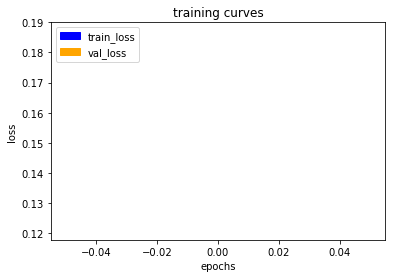

102/102 [==============================] - 105s - loss: 0.1867 - val_loss: 0.1212
Epoch 2/110
101/102 [============================>.] - ETA: 0s - loss: 0.0449

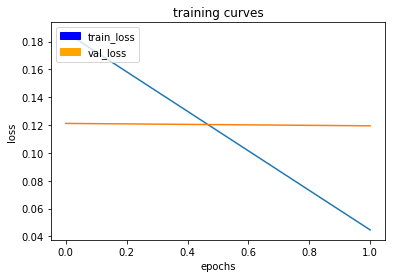

102/102 [==============================] - 75s - loss: 0.0447 - val_loss: 0.1195
Epoch 3/110
101/102 [============================>.] - ETA: 0s - loss: 0.0365

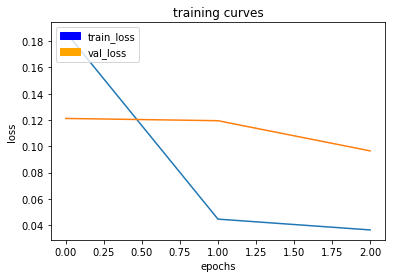

102/102 [==============================] - 74s - loss: 0.0364 - val_loss: 0.0965
Epoch 4/110
101/102 [============================>.] - ETA: 0s - loss: 0.0353

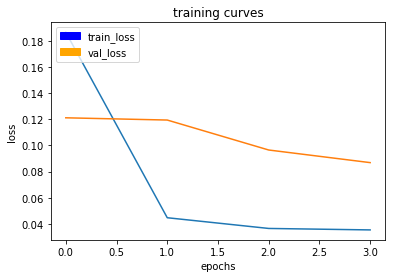

102/102 [==============================] - 74s - loss: 0.0353 - val_loss: 0.0869
Epoch 5/110
101/102 [============================>.] - ETA: 0s - loss: 0.0318

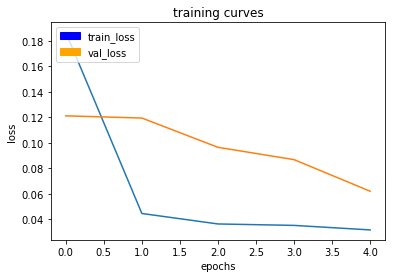

102/102 [==============================] - 74s - loss: 0.0317 - val_loss: 0.0621
Epoch 6/110
101/102 [============================>.] - ETA: 0s - loss: 0.0293

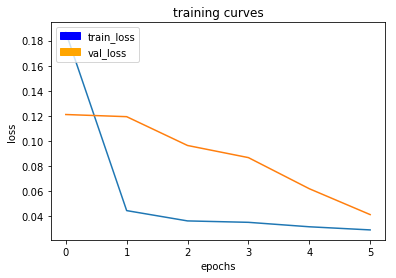

102/102 [==============================] - 74s - loss: 0.0292 - val_loss: 0.0415
Epoch 7/110
101/102 [============================>.] - ETA: 0s - loss: 0.0278

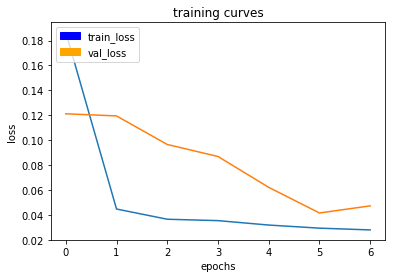

102/102 [==============================] - 75s - loss: 0.0279 - val_loss: 0.0472
Epoch 8/110
101/102 [============================>.] - ETA: 0s - loss: 0.0263

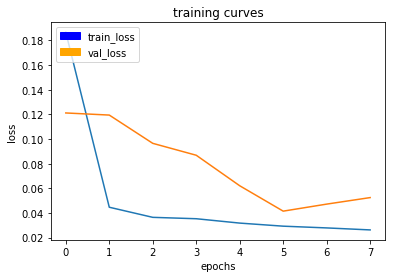

102/102 [==============================] - 74s - loss: 0.0263 - val_loss: 0.0525
Epoch 9/110
101/102 [============================>.] - ETA: 0s - loss: 0.0264

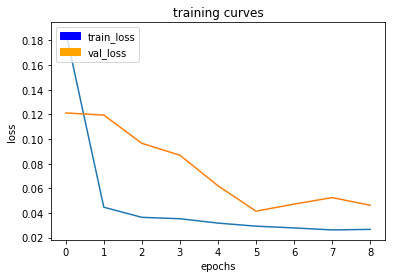

102/102 [==============================] - 74s - loss: 0.0267 - val_loss: 0.0463
Epoch 10/110
101/102 [============================>.] - ETA: 0s - loss: 0.0251

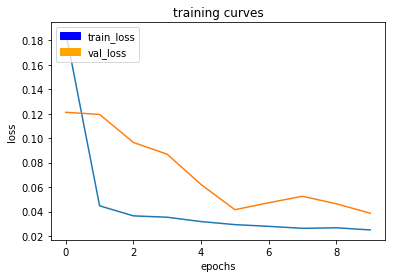

102/102 [==============================] - 75s - loss: 0.0251 - val_loss: 0.0387
Epoch 11/110
101/102 [============================>.] - ETA: 0s - loss: 0.0231

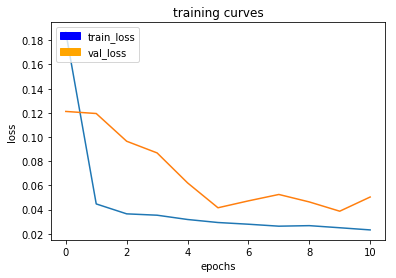

102/102 [==============================] - 74s - loss: 0.0231 - val_loss: 0.0504
Epoch 12/110
101/102 [============================>.] - ETA: 0s - loss: 0.0216

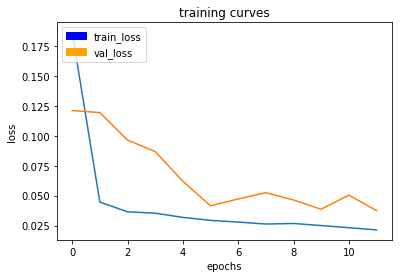

102/102 [==============================] - 74s - loss: 0.0215 - val_loss: 0.0375
Epoch 13/110
101/102 [============================>.] - ETA: 0s - loss: 0.0234

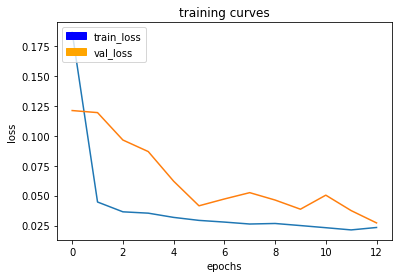

102/102 [==============================] - 74s - loss: 0.0234 - val_loss: 0.0272
Epoch 14/110
101/102 [============================>.] - ETA: 0s - loss: 0.0196

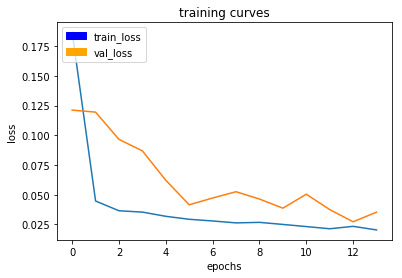

102/102 [==============================] - 74s - loss: 0.0203 - val_loss: 0.0353
Epoch 15/110
101/102 [============================>.] - ETA: 0s - loss: 0.0210

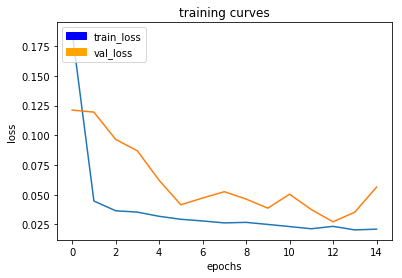

102/102 [==============================] - 74s - loss: 0.0210 - val_loss: 0.0563
Epoch 16/110
101/102 [============================>.] - ETA: 0s - loss: 0.0198

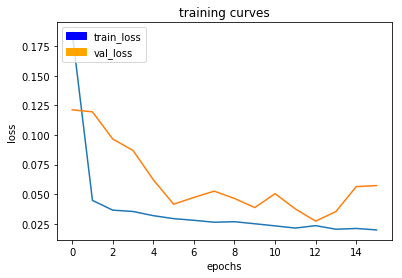

102/102 [==============================] - 75s - loss: 0.0198 - val_loss: 0.0572
Epoch 17/110
101/102 [============================>.] - ETA: 0s - loss: 0.0214

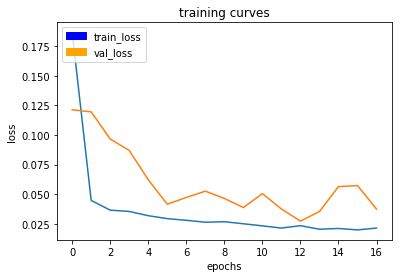

102/102 [==============================] - 75s - loss: 0.0213 - val_loss: 0.0374
Epoch 18/110
101/102 [============================>.] - ETA: 0s - loss: 0.0185

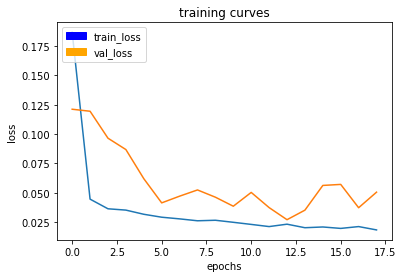

102/102 [==============================] - 74s - loss: 0.0185 - val_loss: 0.0506
Epoch 19/110
101/102 [============================>.] - ETA: 0s - loss: 0.0187

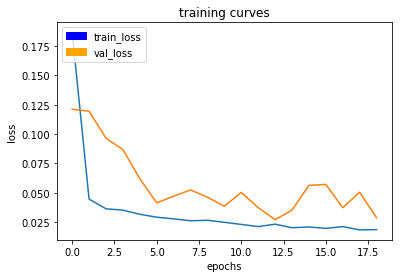

102/102 [==============================] - 74s - loss: 0.0187 - val_loss: 0.0288
Epoch 20/110
101/102 [============================>.] - ETA: 0s - loss: 0.0176

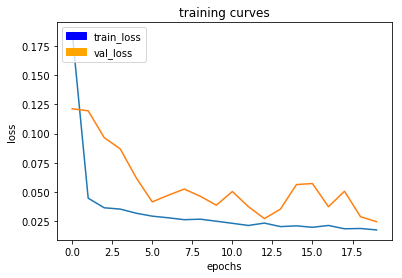

102/102 [==============================] - 75s - loss: 0.0176 - val_loss: 0.0245
Epoch 21/110
101/102 [============================>.] - ETA: 0s - loss: 0.0191

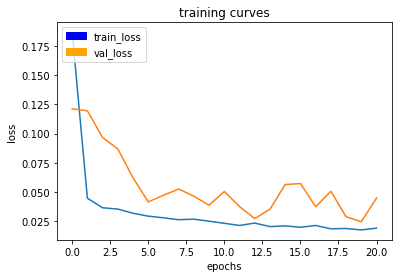

102/102 [==============================] - 74s - loss: 0.0190 - val_loss: 0.0448
Epoch 22/110
101/102 [============================>.] - ETA: 0s - loss: 0.0186

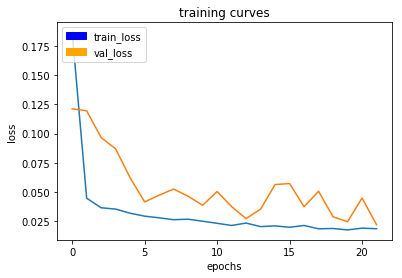

102/102 [==============================] - 75s - loss: 0.0186 - val_loss: 0.0220
Epoch 23/110
101/102 [============================>.] - ETA: 0s - loss: 0.0163

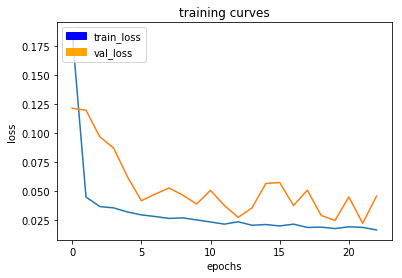

102/102 [==============================] - 74s - loss: 0.0163 - val_loss: 0.0454
Epoch 24/110
101/102 [============================>.] - ETA: 0s - loss: 0.0189

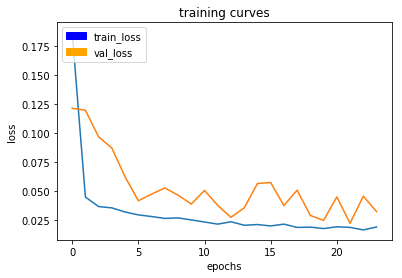

102/102 [==============================] - 75s - loss: 0.0189 - val_loss: 0.0321
Epoch 25/110
101/102 [============================>.] - ETA: 0s - loss: 0.0161

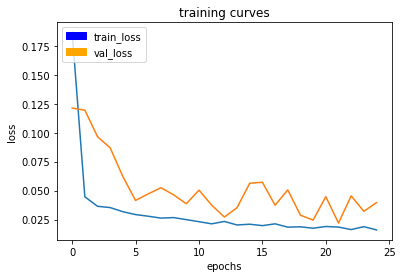

102/102 [==============================] - 74s - loss: 0.0160 - val_loss: 0.0397
Epoch 26/110
101/102 [============================>.] - ETA: 0s - loss: 0.0167

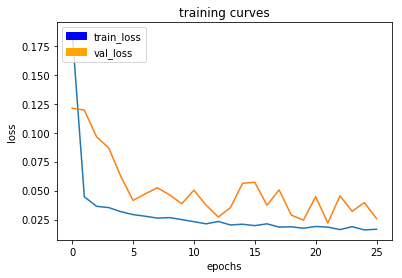

102/102 [==============================] - 74s - loss: 0.0166 - val_loss: 0.0259
Epoch 27/110
101/102 [============================>.] - ETA: 0s - loss: 0.0164

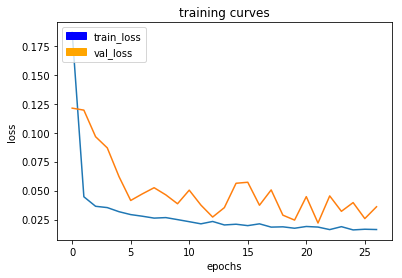

102/102 [==============================] - 74s - loss: 0.0164 - val_loss: 0.0361
Epoch 28/110
101/102 [============================>.] - ETA: 0s - loss: 0.0167

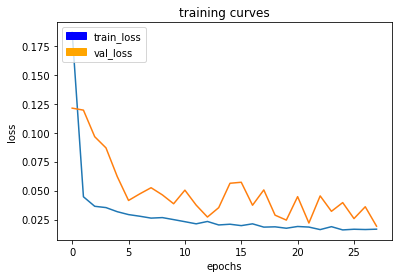

102/102 [==============================] - 74s - loss: 0.0167 - val_loss: 0.0193
Epoch 29/110
101/102 [============================>.] - ETA: 0s - loss: 0.0159

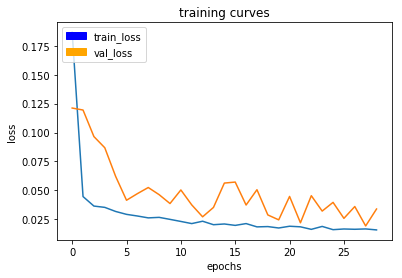

102/102 [==============================] - 74s - loss: 0.0158 - val_loss: 0.0339
Epoch 30/110
101/102 [============================>.] - ETA: 0s - loss: 0.0166

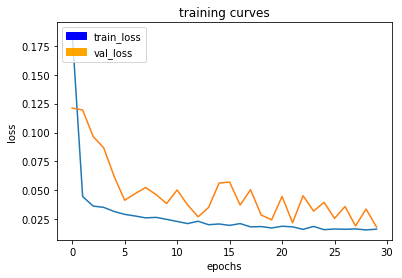

102/102 [==============================] - 74s - loss: 0.0165 - val_loss: 0.0184
Epoch 31/110
101/102 [============================>.] - ETA: 0s - loss: 0.0143

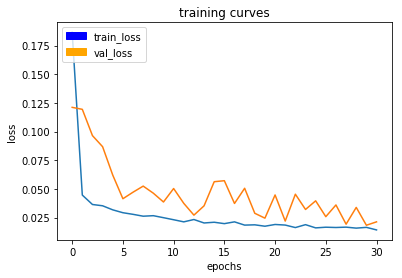

102/102 [==============================] - 75s - loss: 0.0143 - val_loss: 0.0213
Epoch 32/110
101/102 [============================>.] - ETA: 0s - loss: 0.0151

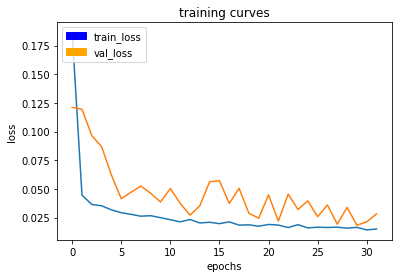

102/102 [==============================] - 74s - loss: 0.0151 - val_loss: 0.0283
Epoch 33/110
101/102 [============================>.] - ETA: 0s - loss: 0.0147

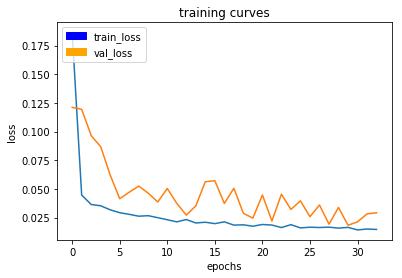

102/102 [==============================] - 74s - loss: 0.0147 - val_loss: 0.0293
Epoch 34/110
101/102 [============================>.] - ETA: 0s - loss: 0.0151

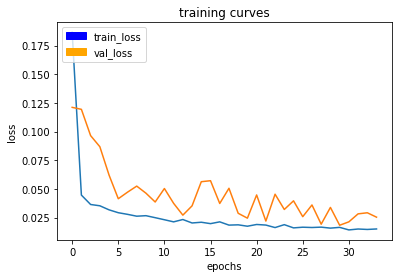

102/102 [==============================] - 74s - loss: 0.0151 - val_loss: 0.0254
Epoch 35/110
101/102 [============================>.] - ETA: 0s - loss: 0.0154

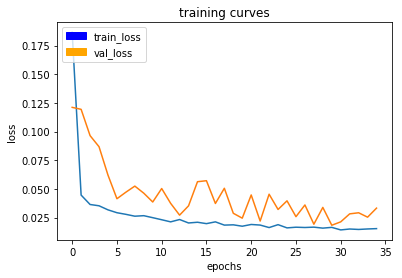

102/102 [==============================] - 74s - loss: 0.0154 - val_loss: 0.0333
Epoch 36/110
101/102 [============================>.] - ETA: 0s - loss: 0.0148

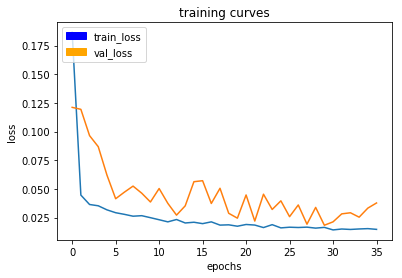

102/102 [==============================] - 75s - loss: 0.0148 - val_loss: 0.0378
Epoch 37/110
101/102 [============================>.] - ETA: 0s - loss: 0.0163

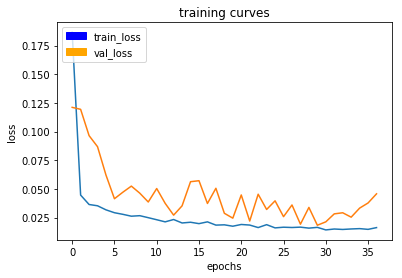

102/102 [==============================] - 75s - loss: 0.0163 - val_loss: 0.0458
Epoch 38/110
101/102 [============================>.] - ETA: 0s - loss: 0.0157

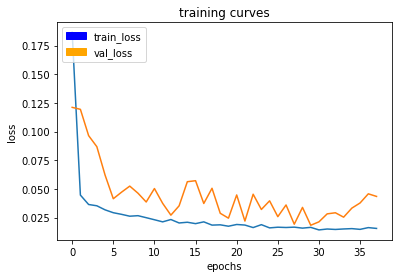

102/102 [==============================] - 74s - loss: 0.0156 - val_loss: 0.0435
Epoch 39/110
101/102 [============================>.] - ETA: 0s - loss: 0.0134

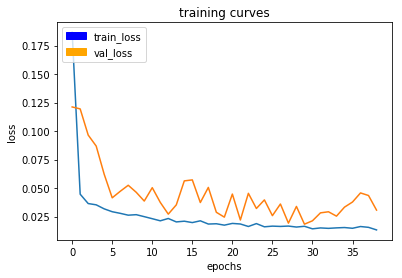

102/102 [==============================] - 75s - loss: 0.0133 - val_loss: 0.0307
Epoch 40/110
101/102 [============================>.] - ETA: 0s - loss: 0.0144

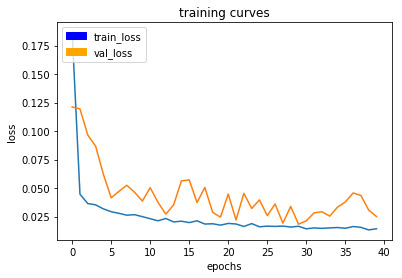

102/102 [==============================] - 74s - loss: 0.0143 - val_loss: 0.0250
Epoch 41/110
101/102 [============================>.] - ETA: 0s - loss: 0.0129

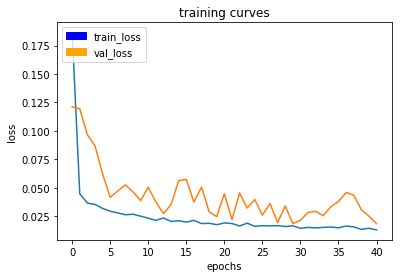

102/102 [==============================] - 74s - loss: 0.0129 - val_loss: 0.0183
Epoch 42/110
101/102 [============================>.] - ETA: 0s - loss: 0.0123

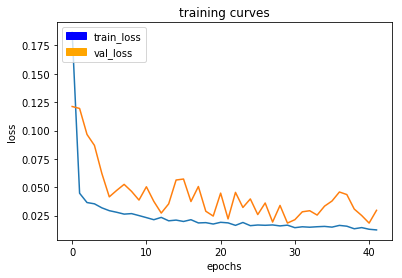

102/102 [==============================] - 74s - loss: 0.0123 - val_loss: 0.0296
Epoch 43/110
101/102 [============================>.] - ETA: 0s - loss: 0.0157

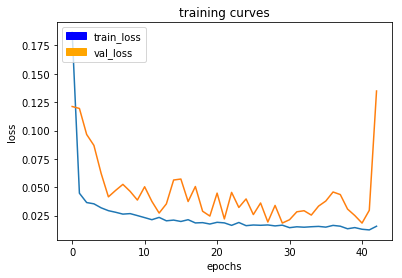

102/102 [==============================] - 74s - loss: 0.0158 - val_loss: 0.1349
Epoch 44/110
101/102 [============================>.] - ETA: 0s - loss: 0.0189

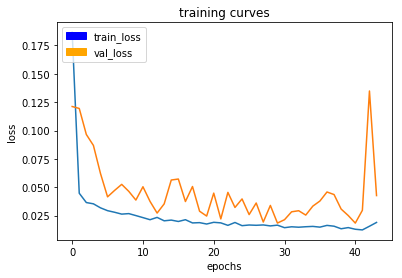

102/102 [==============================] - 74s - loss: 0.0189 - val_loss: 0.0426
Epoch 45/110
101/102 [============================>.] - ETA: 0s - loss: 0.0148

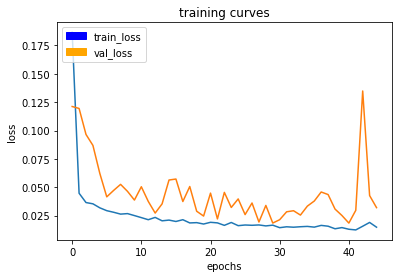

102/102 [==============================] - 74s - loss: 0.0148 - val_loss: 0.0320
Epoch 46/110
101/102 [============================>.] - ETA: 0s - loss: 0.0140

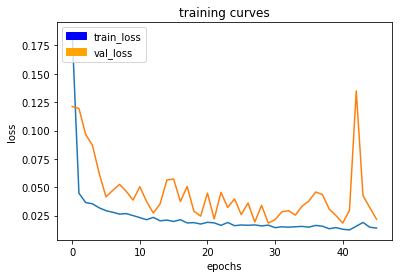

102/102 [==============================] - 74s - loss: 0.0139 - val_loss: 0.0218
Epoch 47/110
101/102 [============================>.] - ETA: 0s - loss: 0.0133

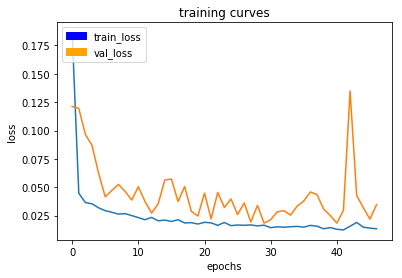

102/102 [==============================] - 74s - loss: 0.0133 - val_loss: 0.0346
Epoch 48/110
101/102 [============================>.] - ETA: 0s - loss: 0.0134

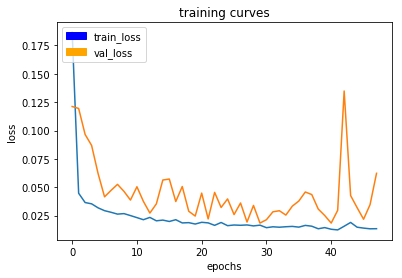

102/102 [==============================] - 74s - loss: 0.0134 - val_loss: 0.0622
Epoch 49/110
101/102 [============================>.] - ETA: 0s - loss: 0.0145

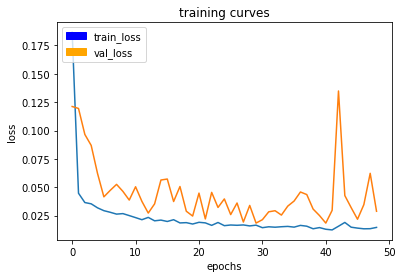

102/102 [==============================] - 75s - loss: 0.0145 - val_loss: 0.0288
Epoch 50/110
101/102 [============================>.] - ETA: 0s - loss: 0.0120

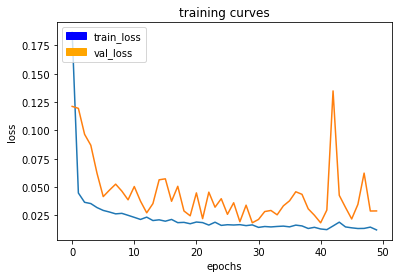

102/102 [==============================] - 74s - loss: 0.0121 - val_loss: 0.0288
Epoch 51/110
101/102 [============================>.] - ETA: 0s - loss: 0.0140

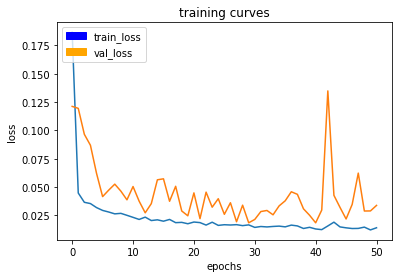

102/102 [==============================] - 75s - loss: 0.0140 - val_loss: 0.0337
Epoch 52/110
101/102 [============================>.] - ETA: 0s - loss: 0.0147

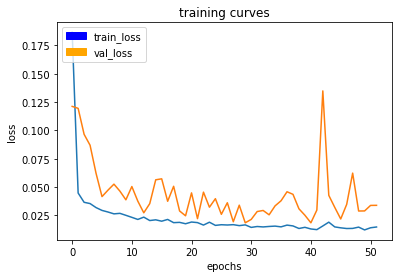

102/102 [==============================] - 74s - loss: 0.0146 - val_loss: 0.0338
Epoch 53/110
101/102 [============================>.] - ETA: 0s - loss: 0.0136

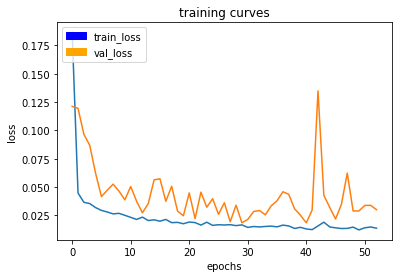

102/102 [==============================] - 75s - loss: 0.0136 - val_loss: 0.0299
Epoch 54/110
101/102 [============================>.] - ETA: 0s - loss: 0.0124

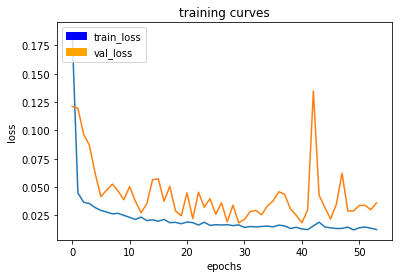

102/102 [==============================] - 74s - loss: 0.0124 - val_loss: 0.0359
Epoch 55/110
101/102 [============================>.] - ETA: 0s - loss: 0.0117

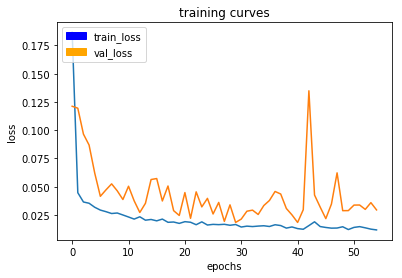

102/102 [==============================] - 74s - loss: 0.0117 - val_loss: 0.0294
Epoch 56/110
101/102 [============================>.] - ETA: 0s - loss: 0.0117

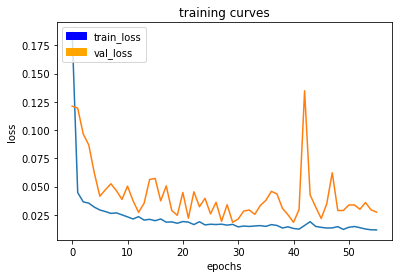

102/102 [==============================] - 75s - loss: 0.0116 - val_loss: 0.0273
Epoch 57/110
101/102 [============================>.] - ETA: 0s - loss: 0.0112

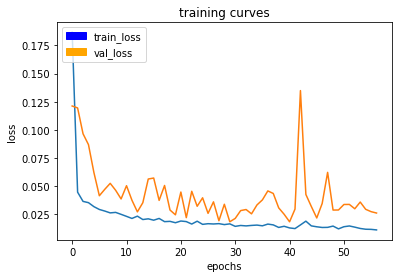

102/102 [==============================] - 74s - loss: 0.0111 - val_loss: 0.0261
Epoch 58/110
101/102 [============================>.] - ETA: 0s - loss: 0.0109

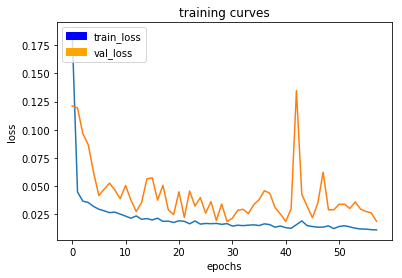

102/102 [==============================] - 74s - loss: 0.0109 - val_loss: 0.0185
Epoch 59/110
101/102 [============================>.] - ETA: 0s - loss: 0.0120

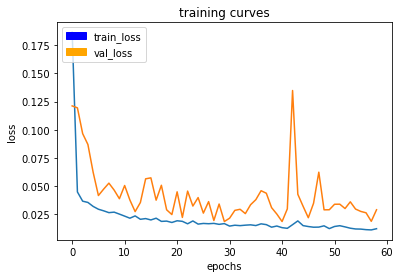

102/102 [==============================] - 75s - loss: 0.0119 - val_loss: 0.0288
Epoch 60/110
101/102 [============================>.] - ETA: 0s - loss: 0.0109

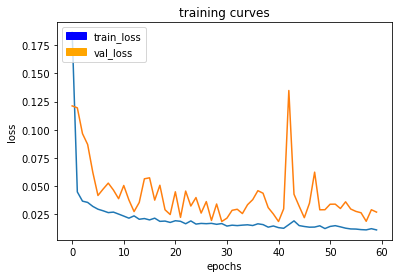

102/102 [==============================] - 74s - loss: 0.0109 - val_loss: 0.0267
Epoch 61/110
101/102 [============================>.] - ETA: 0s - loss: 0.0121

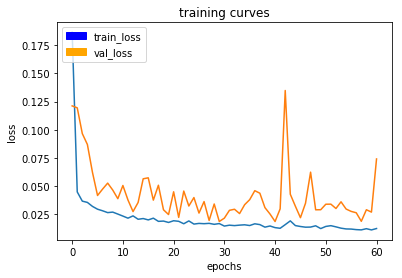

102/102 [==============================] - 74s - loss: 0.0121 - val_loss: 0.0740
Epoch 62/110
101/102 [============================>.] - ETA: 0s - loss: 0.0135

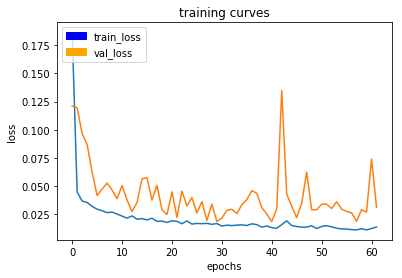

102/102 [==============================] - 75s - loss: 0.0135 - val_loss: 0.0311
Epoch 63/110
101/102 [============================>.] - ETA: 0s - loss: 0.0117

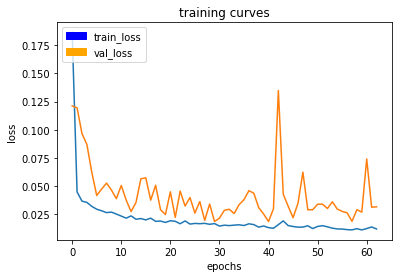

102/102 [==============================] - 73s - loss: 0.0118 - val_loss: 0.0314
Epoch 64/110
101/102 [============================>.] - ETA: 0s - loss: 0.0126

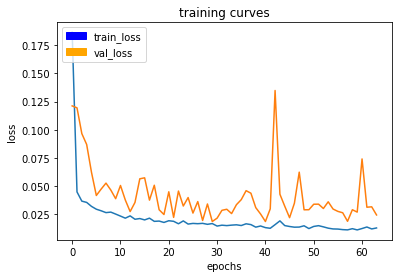

102/102 [==============================] - 72s - loss: 0.0126 - val_loss: 0.0242
Epoch 65/110
101/102 [============================>.] - ETA: 0s - loss: 0.0114

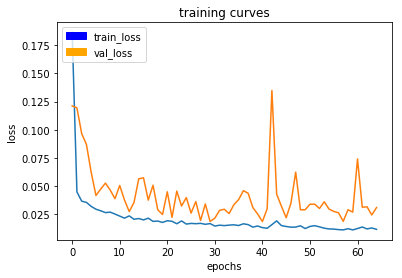

102/102 [==============================] - 72s - loss: 0.0114 - val_loss: 0.0308
Epoch 66/110
101/102 [============================>.] - ETA: 0s - loss: 0.0109

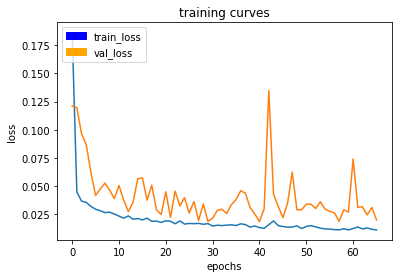

102/102 [==============================] - 72s - loss: 0.0109 - val_loss: 0.0198
Epoch 67/110
101/102 [============================>.] - ETA: 0s - loss: 0.0140

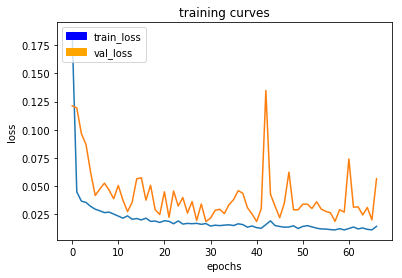

102/102 [==============================] - 72s - loss: 0.0140 - val_loss: 0.0565
Epoch 68/110
101/102 [============================>.] - ETA: 0s - loss: 0.0170

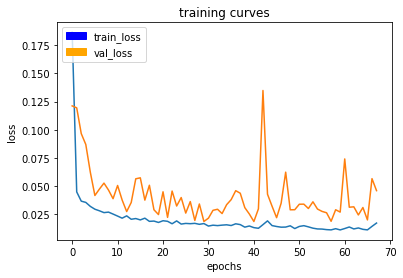

102/102 [==============================] - 72s - loss: 0.0170 - val_loss: 0.0458
Epoch 69/110
101/102 [============================>.] - ETA: 0s - loss: 0.0133

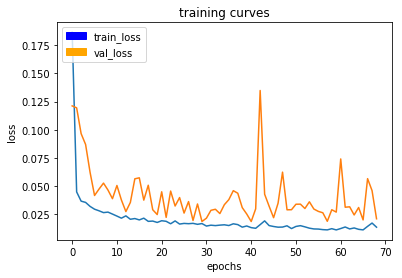

102/102 [==============================] - 72s - loss: 0.0133 - val_loss: 0.0208
Epoch 70/110
101/102 [============================>.] - ETA: 0s - loss: 0.0111

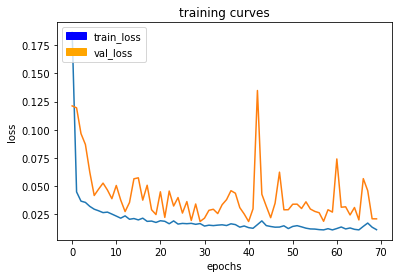

102/102 [==============================] - 72s - loss: 0.0111 - val_loss: 0.0207
Epoch 71/110
101/102 [============================>.] - ETA: 0s - loss: 0.0122

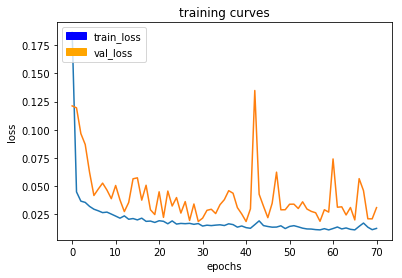

102/102 [==============================] - 72s - loss: 0.0122 - val_loss: 0.0307
Epoch 72/110
101/102 [============================>.] - ETA: 0s - loss: 0.0114

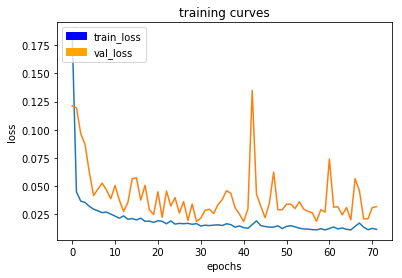

102/102 [==============================] - 72s - loss: 0.0114 - val_loss: 0.0316
Epoch 73/110
101/102 [============================>.] - ETA: 0s - loss: 0.0117

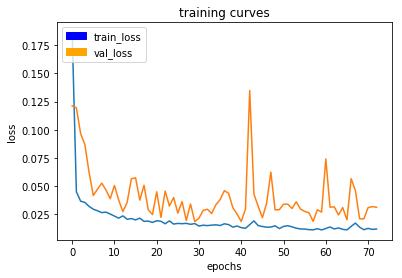

102/102 [==============================] - 72s - loss: 0.0117 - val_loss: 0.0310
Epoch 74/110
101/102 [============================>.] - ETA: 0s - loss: 0.0108

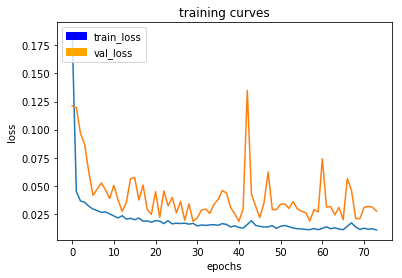

102/102 [==============================] - 72s - loss: 0.0107 - val_loss: 0.0275
Epoch 75/110
101/102 [============================>.] - ETA: 0s - loss: 0.0101

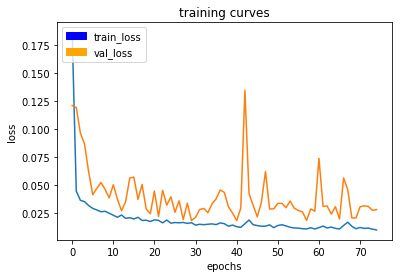

102/102 [==============================] - 72s - loss: 0.0101 - val_loss: 0.0283
Epoch 76/110
101/102 [============================>.] - ETA: 0s - loss: 0.0100

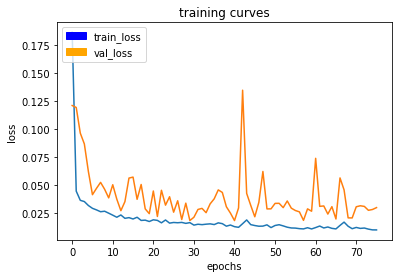

102/102 [==============================] - 72s - loss: 0.0100 - val_loss: 0.0299
Epoch 77/110
101/102 [============================>.] - ETA: 0s - loss: 0.0097

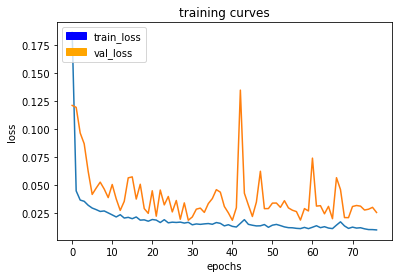

102/102 [==============================] - 72s - loss: 0.0097 - val_loss: 0.0254
Epoch 78/110
101/102 [============================>.] - ETA: 0s - loss: 0.0104

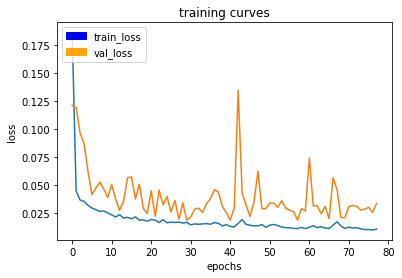

102/102 [==============================] - 72s - loss: 0.0104 - val_loss: 0.0334
Epoch 79/110
101/102 [============================>.] - ETA: 0s - loss: 0.0097

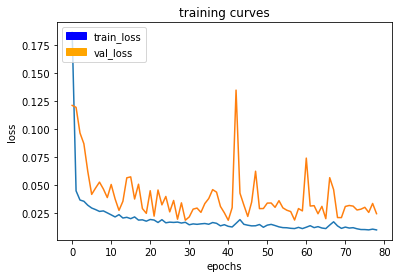

102/102 [==============================] - 72s - loss: 0.0097 - val_loss: 0.0243
Epoch 80/110
101/102 [============================>.] - ETA: 0s - loss: 0.0106

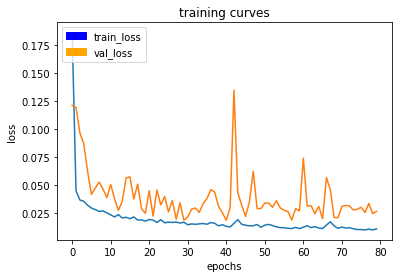

102/102 [==============================] - 72s - loss: 0.0107 - val_loss: 0.0263
Epoch 81/110
101/102 [============================>.] - ETA: 0s - loss: 0.0119

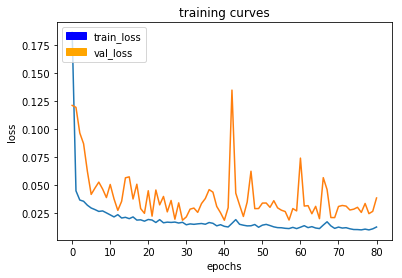

102/102 [==============================] - 72s - loss: 0.0123 - val_loss: 0.0383
Epoch 82/110
101/102 [============================>.] - ETA: 0s - loss: 0.0135

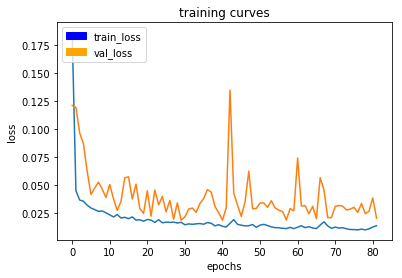

102/102 [==============================] - 72s - loss: 0.0134 - val_loss: 0.0203
Epoch 83/110
101/102 [============================>.] - ETA: 0s - loss: 0.0112

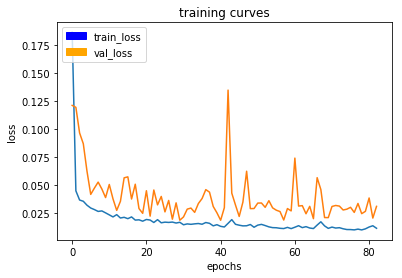

102/102 [==============================] - 72s - loss: 0.0112 - val_loss: 0.0308
Epoch 84/110
101/102 [============================>.] - ETA: 0s - loss: 0.0104

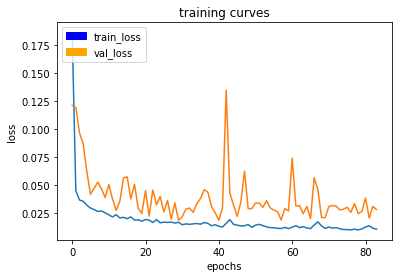

102/102 [==============================] - 72s - loss: 0.0104 - val_loss: 0.0279
Epoch 85/110
101/102 [============================>.] - ETA: 0s - loss: 0.0104

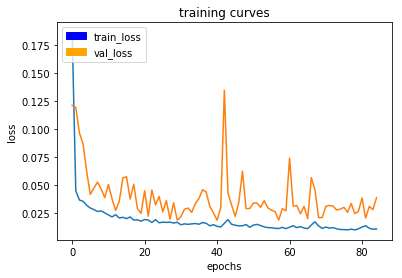

102/102 [==============================] - 72s - loss: 0.0105 - val_loss: 0.0386
Epoch 86/110
101/102 [============================>.] - ETA: 0s - loss: 0.0133

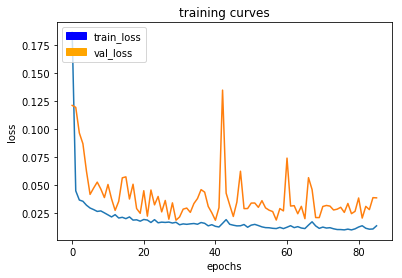

102/102 [==============================] - 72s - loss: 0.0133 - val_loss: 0.0384
Epoch 87/110
101/102 [============================>.] - ETA: 0s - loss: 0.0117

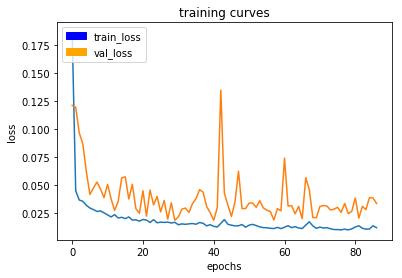

102/102 [==============================] - 72s - loss: 0.0117 - val_loss: 0.0333
Epoch 88/110
101/102 [============================>.] - ETA: 0s - loss: 0.0110

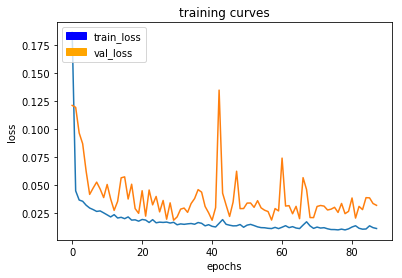

102/102 [==============================] - 72s - loss: 0.0110 - val_loss: 0.0317
Epoch 89/110
101/102 [============================>.] - ETA: 0s - loss: 0.0110

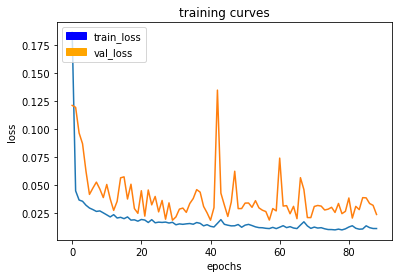

102/102 [==============================] - 72s - loss: 0.0110 - val_loss: 0.0235
Epoch 90/110
101/102 [============================>.] - ETA: 0s - loss: 0.0100

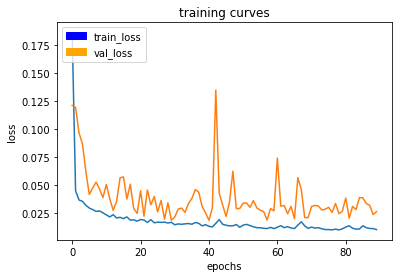

102/102 [==============================] - 72s - loss: 0.0100 - val_loss: 0.0261
Epoch 91/110
101/102 [============================>.] - ETA: 0s - loss: 0.0097

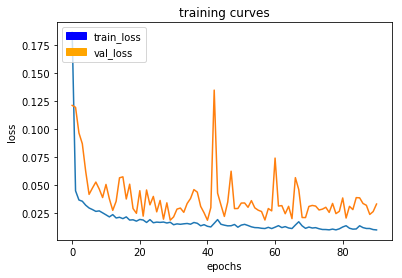

102/102 [==============================] - 72s - loss: 0.0097 - val_loss: 0.0328
Epoch 92/110
101/102 [============================>.] - ETA: 0s - loss: 0.0093

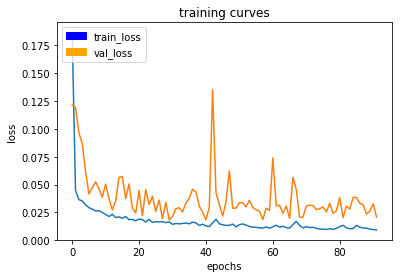

102/102 [==============================] - 72s - loss: 0.0093 - val_loss: 0.0208
Epoch 93/110
101/102 [============================>.] - ETA: 0s - loss: 0.0092

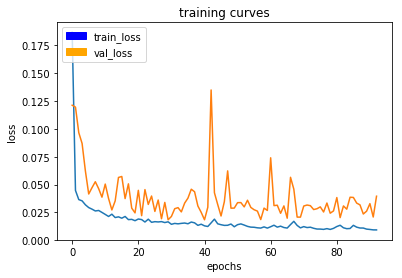

102/102 [==============================] - 72s - loss: 0.0092 - val_loss: 0.0395
Epoch 94/110
101/102 [============================>.] - ETA: 0s - loss: 0.0093

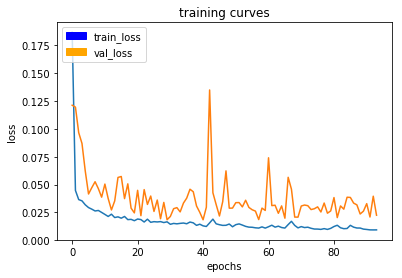

102/102 [==============================] - 72s - loss: 0.0093 - val_loss: 0.0224
Epoch 95/110
101/102 [============================>.] - ETA: 0s - loss: 0.0094

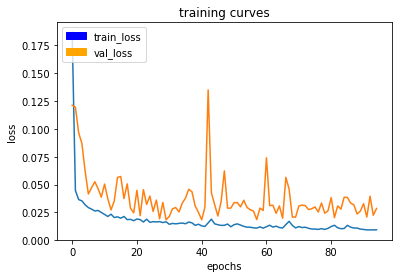

102/102 [==============================] - 72s - loss: 0.0094 - val_loss: 0.0285
Epoch 96/110
101/102 [============================>.] - ETA: 0s - loss: 0.0091

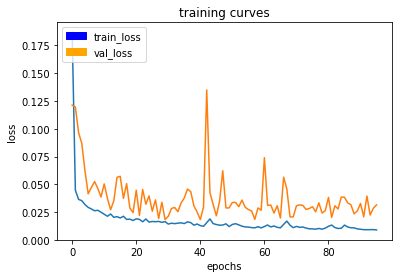

102/102 [==============================] - 72s - loss: 0.0091 - val_loss: 0.0316
Epoch 97/110
101/102 [============================>.] - ETA: 0s - loss: 0.0089

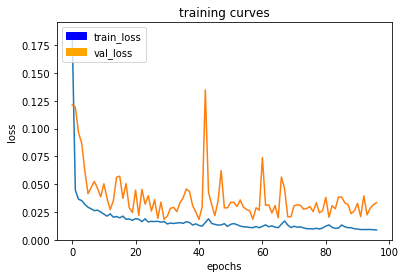

102/102 [==============================] - 72s - loss: 0.0089 - val_loss: 0.0334
Epoch 98/110
101/102 [============================>.] - ETA: 0s - loss: 0.0090

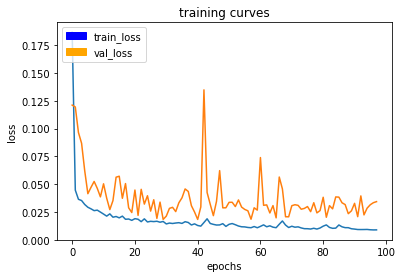

102/102 [==============================] - 72s - loss: 0.0090 - val_loss: 0.0344
Epoch 99/110
101/102 [============================>.] - ETA: 0s - loss: 0.0088

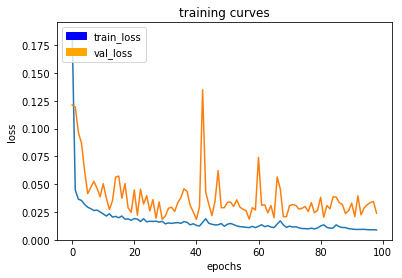

102/102 [==============================] - 72s - loss: 0.0088 - val_loss: 0.0239
Epoch 100/110
101/102 [============================>.] - ETA: 0s - loss: 0.0089

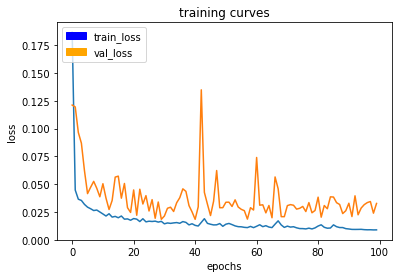

102/102 [==============================] - 72s - loss: 0.0089 - val_loss: 0.0326
Epoch 101/110
101/102 [============================>.] - ETA: 0s - loss: 0.0089

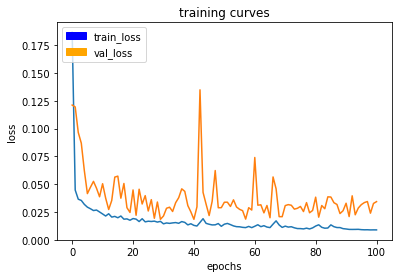

102/102 [==============================] - 72s - loss: 0.0089 - val_loss: 0.0343
Epoch 102/110
101/102 [============================>.] - ETA: 0s - loss: 0.0099

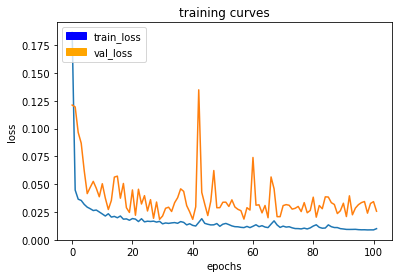

102/102 [==============================] - 72s - loss: 0.0100 - val_loss: 0.0256
Epoch 103/110
101/102 [============================>.] - ETA: 0s - loss: 0.0138

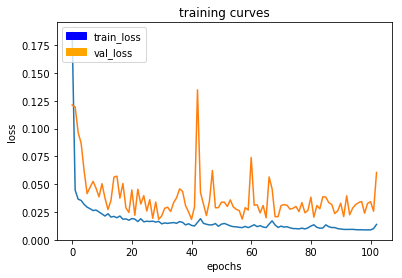

102/102 [==============================] - 72s - loss: 0.0138 - val_loss: 0.0605
Epoch 104/110
101/102 [============================>.] - ETA: 0s - loss: 0.0148

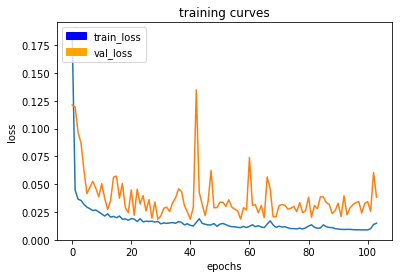

102/102 [==============================] - 73s - loss: 0.0148 - val_loss: 0.0383
Epoch 105/110
101/102 [============================>.] - ETA: 0s - loss: 0.0116

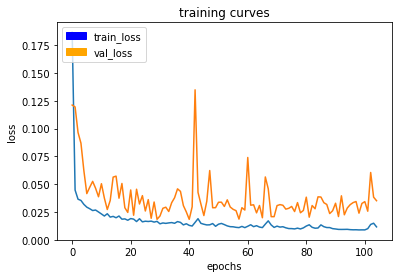

102/102 [==============================] - 73s - loss: 0.0116 - val_loss: 0.0351
Epoch 106/110
101/102 [============================>.] - ETA: 0s - loss: 0.0102

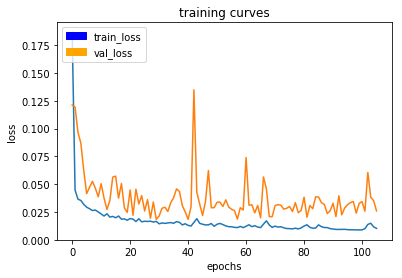

102/102 [==============================] - 72s - loss: 0.0102 - val_loss: 0.0259
Epoch 107/110
101/102 [============================>.] - ETA: 0s - loss: 0.0096

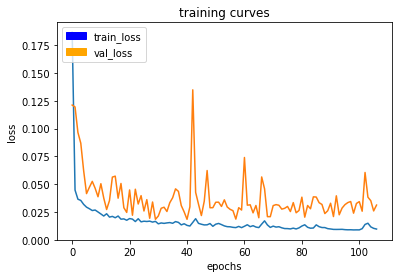

102/102 [==============================] - 72s - loss: 0.0096 - val_loss: 0.0312
Epoch 108/110
101/102 [============================>.] - ETA: 0s - loss: 0.0094

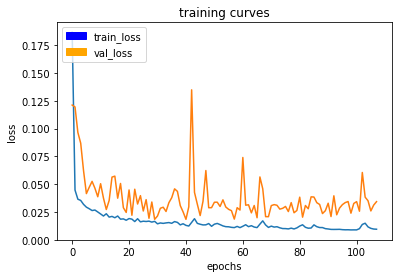

102/102 [==============================] - 72s - loss: 0.0094 - val_loss: 0.0343
Epoch 109/110
101/102 [============================>.] - ETA: 0s - loss: 0.0094

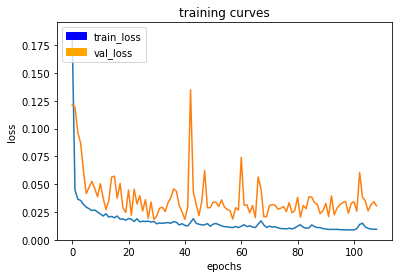

102/102 [==============================] - 72s - loss: 0.0094 - val_loss: 0.0304
Epoch 110/110
101/102 [============================>.] - ETA: 0s - loss: 0.0090

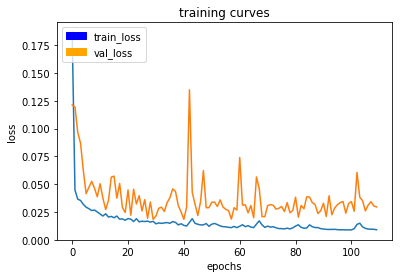

102/102 [==============================] - 72s - loss: 0.0090 - val_loss: 0.0295
Done


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

print("Done")

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [11]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

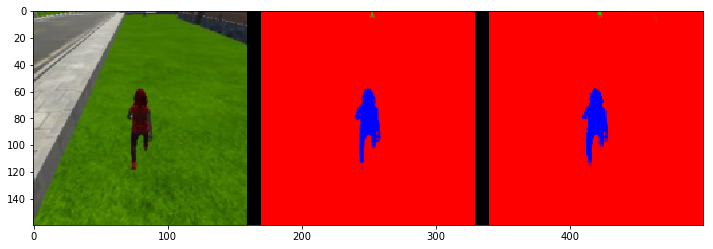

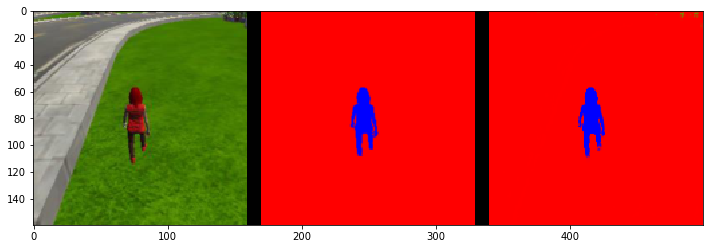

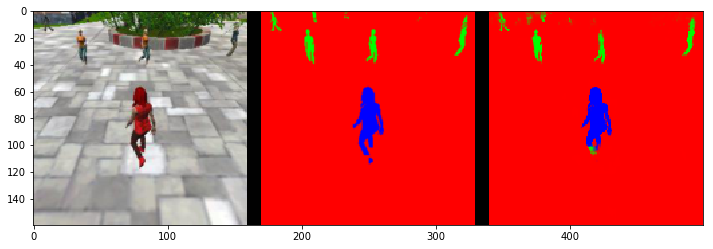

In [12]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

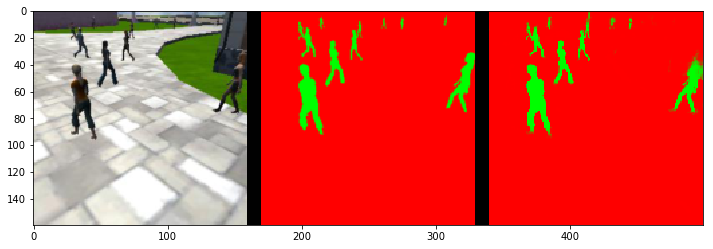

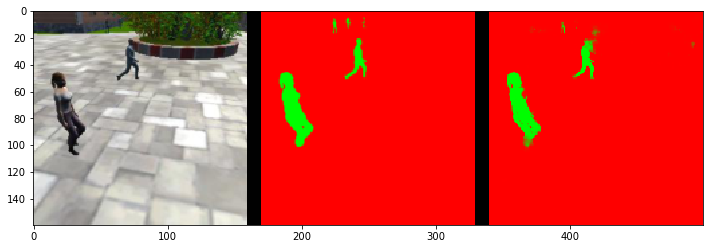

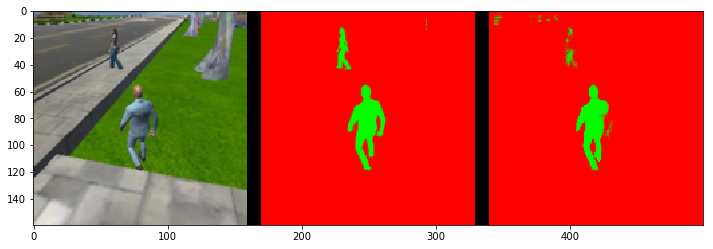

In [13]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

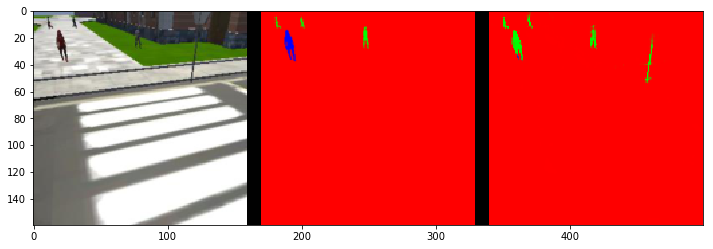

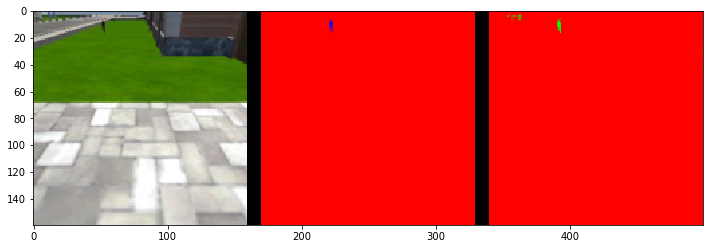

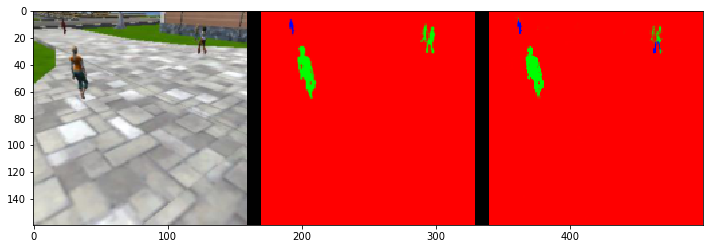

In [14]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [15]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9965517894809127
average intersection over union for other people is 0.40959005956544353
average intersection over union for the hero is 0.9188471372309986
number true positives: 539, number false positives: 0, number false negatives: 0


In [16]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9887652394453698
average intersection over union for other people is 0.7716460685229736
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 42, number false negatives: 0


In [17]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9968831393990336
average intersection over union for other people is 0.486603248672771
average intersection over union for the hero is 0.26847366789318483
number true positives: 137, number false positives: 2, number false negatives: 164


In [18]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7647058823529411


In [19]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.593660402562


In [20]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.453975601959
